In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

from PIL import Image
import math

In [2]:
crop_size = 4
img_dir = "imgs/elephant.png"

data_qb = int(math.log2(crop_size**2))
anc_qb = 1
total_qb = data_qb + anc_qb
print(f"Total Qubits: {total_qb}")

os.makedirs("result_image_device", exist_ok=True)

Total Qubits: 5


Crop the image

In [3]:


# Function for plotting the image using matplotlib
def plot_image(img, i, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='binary')
    plt.savefig(f"result_image_device/{title}_{i}.jpg")
    plt.close()
    # plt.show()
    
    np.save(f"result_image_device/{title}_{i}.npy", img)
    
# plot_image(image, 'Original Image')


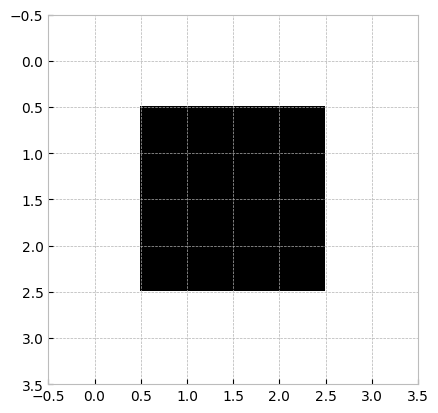

Original Image Shape: (4, 4)
Cropped Image Shape: (1, 4, 4)


In [4]:
# image = np.array(Image.open(img_dir).convert('L'))
# image = image[136:152, 79:95]
image = np.array([[0, 0, 0, 0],
                  [0, 255, 255, 0],
                  [0, 255, 255, 0],
                  [0, 0, 0, 0]])
plt.imshow(image, cmap='binary')
plt.show()
print(f"Original Image Shape: {image.shape}")

original_img = [image.shape[0], image.shape[1]]
times = int(image.shape[0]/crop_size)
crop_image = np.zeros((times**2, crop_size, crop_size))
for i in range(times):
    for j in range(times):
        crop_image[i*times+j] = image[i*crop_size:(i+1)*crop_size, j*crop_size:(j+1)*crop_size]
image = crop_image

print(f"Cropped Image Shape: {image.shape}")


In [5]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt((np.sum(np.square(img_data, dtype='float64'), axis=None)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = np.asarray([amplitude_encode(image[i]) for i in range(image.shape[0])])

# Vertical: Transpose of Original image
image_norm_v = np.asarray([amplitude_encode(image[i].T) for i in range(image.shape[0])])

In [6]:
# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [7]:
def generateCircuit(image_norm_h, image_norm_v):

    # Create the circuit for horizontal scan
    qc_h = QuantumCircuit(total_qb)
    qc_h.initialize(image_norm_h, range(1, total_qb))
    qc_h.h(0)
    qc_h.unitary(D2n_1, range(total_qb))
    qc_h.h(0)
    qc_h.measure_all()
    # display(qc_h.draw('mpl', fold=-1))

    # Create the circuit for vertical scan
    qc_v = QuantumCircuit(total_qb)
    qc_v.initialize(image_norm_v, range(1, total_qb))
    qc_v.h(0)
    qc_v.unitary(D2n_1, range(total_qb))
    qc_v.h(0)
    qc_v.measure_all()
    # display(qc_v.draw('mpl', fold=-1))

    # Combine both circuits into a single list
    circ_list = [qc_h, qc_v]
    
    return qc_h, qc_v, circ_list

In [8]:
def QuantumSimulate(qc_h, qc_v, circ_list):
    # Simulating the cirucits
    back = Aer.get_backend('statevector_simulator')
    results = execute(circ_list, backend=back).result()
    sv_h = results.get_statevector(qc_h)
    sv_v = results.get_statevector(qc_v)

    from qiskit.visualization import array_to_latex
    print('Horizontal scan statevector:')
    # display(array_to_latex(sv_h[:30], max_size=30))
    print()
    print('Vertical scan statevector:')
    # display(array_to_latex(sv_v[:30], max_size=30))
    
    return sv_h, sv_v

In [9]:
def scanEdge(sv_h, sv_v):
    edge_scan_h = np.array([sv_h[f'{2*i+1:0{total_qb}b}'].real for i in range(2**data_qb)]).reshape(crop_size, crop_size)
    edge_scan_v = np.array([sv_v[f'{2*i+1:0{total_qb}b}'].real for i in range(2**data_qb)]).reshape(crop_size, crop_size).T

    return edge_scan_h, edge_scan_v

In [10]:
Total_scan_h = []
Total_scan_v = []
circ_list_all = []
for i in range(image_norm_h.shape[0]):
    # print(f"Idx: {i}")
    qc_h, qc_v, circ_list = generateCircuit(image_norm_h[i], image_norm_v[i])
    circ_list_all.append(circ_list)
    

In [11]:
# Load the IBMQ account
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ
IBMQ.load_account()

# Get the provider and backend
provider = IBMQ.get_provider(hub='ibm-q', group='open')
backend = provider.get_backend('ibm_osaka')

results = []
edge_scan_result = []

Total_scan_h = []
Total_scan_v = []

for i, circ in enumerate(circ_list_all):
    # Transpile the circuits for optimized execution on the backend
    qc_h_t = transpile(circ[0], backend=backend, optimization_level=3)
    qc_v_t = transpile(circ[1], backend=backend, optimization_level=3)
    circ_list_t = [qc_h_t, qc_v_t]
    job = execute(circ_list_t, backend=backend, shots=4096)
    job_monitor(job)
    result = job.result()
    counts_h = result.get_counts(qc_h_t)
    counts_v = result.get_counts(qc_v_t)
    results.append([counts_h, counts_v])
    edge_scan_small_h = np.array([counts_h[f'{2*i+1:0{total_qb}b}'] for i in range(2**data_qb)]).reshape(crop_size, crop_size)
    edge_scan_small_v = np.array([counts_v[f'{2*i+1:0{total_qb}b}'] for i in range(2**data_qb)]).reshape(crop_size, crop_size).T
    Total_scan_h.append(edge_scan_small_h) #[16, 128, 128]
    Total_scan_v.append(edge_scan_small_v)
    edge_scan_result.append([edge_scan_small_h, edge_scan_small_v])

    # npy saved in plot_image
    plot_image(edge_scan_small_h, i=i, title='Horizontal')
    plot_image(edge_scan_small_v, i=i, title='Vertical')

/tmp/ipykernel_1783/3136128719.py:4: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


Job Status: job has successfully run


In [12]:
Total_scan_h = np.asarray(Total_scan_h)   
Total_scan_v = np.asarray(Total_scan_v)
Result_h = np.zeros((16, 16))
Result_v = np.zeros((16, 16))

for i in range(times):
    for j in range(times):
        Result_h[crop_size*i:crop_size*(i+1), crop_size*j:crop_size*(j+1)] = Total_scan_h[i*(times)+j,:,:] 
        Result_v[crop_size*i:crop_size*(i+1), crop_size*j:crop_size*(j+1)] = Total_scan_v[i*(times)+j,:,:]

plot_image(Result_h, i=i, title='Result_Horizontal')
plot_image(Result_v, i=i, title='Result_Vertical')

In [13]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
# thr = 2e-20
# threshold = lambda amp: (amp > thr or amp < -thr)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
# edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image.shape[0], image.shape[1])
# edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image.shape[0], image.shape[1]).T


# Plotting the Horizontal and vertical scans
# plot_image(edge_scan_h, 'Horizontal scan output')
# plot_image(edge_scan_v, 'Vertical scan output')

# plot_image(edge_scan_h, 'Horizontal scan output')
# plot_image(edge_scan_v, 'Vertical scan output')

In [14]:
# Combining the horizontal and vertical component of the result
# edge_scan_sim = edge_scan_h  | edge_scan_v
# edge_scan_sim = edge_scan_h*0.5 + edge_scan_v*0.5

# # Plotting the original and edge-detected images
# plot_image(image, 'Original image')
# plot_image(edge_scan_sim, 'Edge Detected image')